## Install all required packages

In [1]:
!pip install matplotlib==3.5.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.3 MB 5.3 MB/s 
     |████████████████████████████████| 965 kB 37.6 MB/s 
     |████████████████████████████████| 42 kB 476 kB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [1]:
import matplotlib
matplotlib.__version__
assert matplotlib.__version__ == '3.5.0' # if this fails, makes sure you ran the matplotlib installation above AND restarted your runtime

In [2]:
%%shell
pip install torch-scatter -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
pip install torch-sparse -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
pip install torch-geometric
pip install torch-cluster -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
pip install torch-spline-conv -f https://data.pyg.org/whl/torch-1.13.0+cu116.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.0+cu116.html
     |████████████████████████████████| 9.4 MB 2.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.0+cu116.html
     |████████████████████████████████| 4.6 MB 3.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 564 kB 4.9 MB/s 
     |████████████████████████████████| 280 kB 62.8 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.2.0-py3-none-any.whl size=773302 sha256=a0347671956cc8b559f241fcd508299ca5a3055c5d29200410469de0559ec8c1
  Stored in directory: /root/.cache/pip/wheels/59/a3/20/198928106d3169865ae73afcbd3d3d1796cf6b429b55c65378
Successfully built torch-geometric
  Attempting uninstall: psuti

In [3]:
import json
import numpy as np
import os
import torch
import pandas as pd
from torch_geometric import seed_everything
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.utils import degree
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from sklearn.decomposition import PCA
from IPython.display import HTML
import networkx as nx
from networkx.algorithms import bipartite

seed_everything(5) # set random seed

In [4]:
class PlainData(Data):
    """
    Custom Data class for use in PyG. Basically the same as the original Data class from PyG, but
    overrides the __inc__ method because otherwise the DataLoader was incrementing indices unnecessarily.
    Now it functions more like the original DataLoader from PyTorch itself.
    See here for more information: https://pytorch-geometric.readthedocs.io/en/latest/notes/batching.html
    """
    def __inc__(self, key, value, *args, **kwargs):
        return 0

class BIDataset(Dataset):
    """
    Dataset object containing the supervision/evaluation edges. This will be used by the DataLoader to load
    batches of edges to calculate loss or evaluation metrics on. Here, get(idx) will return ALL outgoing edges of the graph
    corresponding to playlist "idx." This is because when calculating metrics such as recall@k, we need all of the
    user's positive edges in the same batch.
    """
    def __init__(self, root, edge_index, transform=None, pre_transform=None):
        self.edge_index = edge_index
        self.unique_idxs = torch.unique(edge_index[0,:]).tolist() # playlists will all be in row 0, b/c sorted by RandLinkSplit
        self.num_nodes = len(self.unique_idxs)
        super().__init__(root, transform, pre_transform)

    def len(self):
        return self.num_nodes

    def get(self, idx): # returns all outgoing edges associated with playlist idx
        edge_index = self.edge_index[:, self.edge_index[0,:] == idx]
        return PlainData(edge_index=edge_index)

In [5]:
class LightGCN(MessagePassing):
    """
    A single LightGCN layer. Extends the MessagePassing class from PyTorch Geometric
    """
    def __init__(self):
        super(LightGCN, self).__init__(aggr='add') # aggregation function is 'add

    def message(self, x_j, norm):
        """
        Specifies how to perform message passing during GNN propagation. For LightGCN, we simply pass along each
        source node's embedding to the target node, normalized by the normalization term for that node.
        args:
          x_j: node embeddings of the neighbor nodes, which will be passed to the central node (shape: [E, emb_dim])
          norm: the normalization terms we calculated in forward() and passed into propagate()
        returns:
          messages from neighboring nodes j to central node i
        """
        # Here we are just multiplying the x_j's by the normalization terms (using some broadcasting)
        return norm.view(-1, 1) * x_j

    def forward(self, x, edge_index):
        """
        Performs the LightGCN message passing/aggregation/update to get updated node embeddings

        args:
          x: current node embeddings (shape: [N, emb_dim])
          edge_index: message passing edges (shape: [2, E])
        returns:
          updated embeddings after this layer
        """
        # Computing node degrees for normalization term in LightGCN (see LightGCN paper for details on this normalization term)
        # These will be used during message passing, to normalize each neighbor's embedding before passing it as a message
        row, col = edge_index
        deg = degree(col)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Begin propagation. Will perform message passing and aggregation and return updated node embeddings.
        return self.propagate(edge_index, x=x, norm=norm)

In [6]:
class GNN(torch.nn.Module):
    """
    Overall graph neural network. Consists of learnable user/item embeddings
    and LightGCN layers.
    """
    def __init__(self, embedding_dim, num_nodes, num_start, num_layers):
        super(GNN, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_nodes = num_nodes         # total number of nodes (users + items / items + sellers) in dataset
        self.num_start = num_start # total number of users/items in dataset
        self.num_layers = num_layers

        # Initialize embeddings for all users and items / items and sellers. Users/Items will have indices from 0...num_users/num_items-1,
        # items/sellers will have indices from num_users/num_items...num_nodes-1
        self.embeddings = torch.nn.Embedding(num_embeddings=self.num_nodes, embedding_dim=self.embedding_dim)
        torch.nn.init.normal_(self.embeddings.weight, std=0.1)

        self.layers = torch.nn.ModuleList() # LightGCN layers
        for _ in range(self.num_layers):
            self.layers.append(LightGCN())

        self.sigmoid = torch.sigmoid

    def forward(self):
        raise NotImplementedError("forward() has not been implemented for the GNN class. Do not use")

    def gnn_propagation(self, edge_index_mp):
        """
        Performs the linear embedding propagation (using the LightGCN layers) and calculates final (multi-scale) embeddings
        for each user/item, which are calculated as a weighted sum of that user/item's embeddings at each layer (from
        0 to self.num_layers). Technically, the weighted sum here is the average, which is what the LightGCN authors recommend.

        args:
          edge_index_mp: a tensor of all (undirected) edges in the graph, which is used for message passing/propagation and
              calculating the multi-scale embeddings. (In contrast to the evaluation/supervision edges, which are distinct
              from the message passing edges and will be used for calculating loss/performance metrics).
        returns:
          final multi-scale embeddings for all users/items
        """
        x = self.embeddings.weight        # layer-0 embeddings

        x_at_each_layer = [x]             # stores embeddings from each layer. Start with layer-0 embeddings
        for i in range(self.num_layers):  # now performing the GNN propagation
            x = self.layers[i](x, edge_index_mp)
            x_at_each_layer.append(x)
        final_embs = torch.stack(x_at_each_layer, dim=0).mean(dim=0) # take average to calculate multi-scale embeddings
        return final_embs

    def predict_scores(self, edge_index, embs):
        """
        Calculates predicted scores for each user/item and item/seller pair in the list of edges. Uses dot product of their embeddings.

        args:
          edge_index: tensor of edges (between users and items/ items and seller) whose scores we will calculate.
          embs: node embeddings for calculating predicted scores (typically the multi-scale embeddings from gnn_propagation())
        returns:
          predicted scores for each user/item and item/seller pair in edge_index
        """
        scores = embs[edge_index[0,:], :] * embs[edge_index[1,:], :] # taking dot product for each playlist/song pair
        scores = scores.sum(dim=1)
        scores = self.sigmoid(scores)
        return scores

    def calc_loss(self, data_mp, data_pos, data_neg):
        """
        The main training step. Performs GNN propagation on message passing edges, to get multi-scale embeddings.
        Then predicts scores for each training example, and calculates Bayesian Personalized Ranking (BPR) loss.

        args:
          data_mp: tensor of edges used for message passing / calculating multi-scale embeddings
          data_pos: set of positive edges that will be used during loss calculation
          data_neg: set of negative edges that will be used during loss calculation
        returns:
          loss calculated on the positive/negative training edges
        """
        # Perform GNN propagation on message passing edges to get final embeddings
        final_embs = self.gnn_propagation(data_mp.edge_index)

        # Get edge prediction scores for all positive and negative evaluation edges
        pos_scores = self.predict_scores(data_pos.edge_index, final_embs)
        neg_scores = self.predict_scores(data_neg.edge_index, final_embs)
        print('pos_score: ' + str(torch.mean(pos_scores)))
        print('neg_score: ' + str(torch.mean(neg_scores)))

        # Calculate loss (using variation of Bayesian Personalized Ranking loss, similar to the one used in official
        # LightGCN implementation at https://github.com/gusye1234/LightGCN-PyTorch/blob/master/code/model.py#L202)
        loss = -torch.log(self.sigmoid(pos_scores - neg_scores)).mean()
        return loss

    def evaluation(self, data_mp, data_pos, k,  flag = 1):
        """
        Performs evaluation on validation or test set. Calculates recall@k.

        args:
          data_mp: message passing edges to use for propagation/calculating multi-scale embeddings
          data_pos: positive edges to use for scoring metrics. Should be no overlap between these edges and data_mp's edges
          k: value of k to use for recall@k
        returns:
          dictionary mapping playlist ID -> recall@k on that playlist
        """
        # Run propagation on the message-passing edges to get multi-scale embeddings
        final_embs = self.gnn_propagation(data_mp.edge_index)

        # Get embeddings of all unique users/items in the batch of evaluation edges
        unique_start = torch.unique_consecutive(data_pos.edge_index[0,:])
        start_emb = final_embs[unique_start, :] # has shape [number of users/items in batch, 64]
        
        # Get embeddings of ALL items/sellers in dataset
        end_emb = final_embs[self.num_start:, :] # has shape [total number of items/sellers in dataset, 64]

        # All ratings for each user/item in batch to each item/seller in entire dataset (using dot product as the scoring function)
        ratings = self.sigmoid(torch.matmul(start_emb, end_emb.t())) 

        # Calculate recall@k
        result,result_2 = recall_at_k(ratings.cpu(), k, self.num_start, data_pos.edge_index.cpu(), 
                             unique_start.cpu(), data_mp.edge_index.cpu(),flag = flag)
        return result,result_2 

In [7]:
def recall_at_k(all_ratings, k, num_start, ground_truth, unique_start, data_mp, flag):
   """
   Calculates recall@k during validation/testing for a single batch.

   args:
     all_ratings: array of shape 
     k: the value of k to use for recall@k
     num_start: the number of start in the dataset
     ground_truth: array of shape [2, X] where each column is a pair of (buyer/item_idx, positive item/seller idx). This is the
        batch that we are calculating metrics on.
     unique_start: 1D vector of length [number of users/items in batch], which specifies which user/item corresponds
        to each row of all_ratings
     data_mp: an array of shape [2, Y]. This is all of the known message-passing edges. We will use this to make sure we
        don't recommend items/sellers that are already known.
  
   """
   # We don't want to recommend items/sellers that are already known
   # Set those to a low rating so they won't be recommended
   known_edges = data_mp[:, data_mp[0,:] < num_start] # removing duplicate edges (since data_mp is undirected). also makes it so
                                                          # that for each column, start idx is in row 0 and song idx is in row 1
   start_to_idx_in_batch = {start: i for i, start in enumerate(unique_start.tolist())}
   exclude_start, exclude_end = [], [] # already-known links. Don't want to recommend these again
   for i in range(known_edges.shape[1]): # looping over all known edges
      st, end = known_edges[:,i].tolist()
      if st in start_to_idx_in_batch: # don't need the edges in data_mp that are from start that are not in this batch
         exclude_start.append(start_to_idx_in_batch[st])
         exclude_end.append(end - num_start) # subtract num_start to get indexing into all_ratings correct
   if flag:
      all_ratings[exclude_start, exclude_end] = -10000 # setting to a very low score so they won't be recommended
   
   # Get top k recommendations for each start
   rate, top_k = torch.topk(all_ratings, k=k, dim=1)
   top_k += num_start # topk returned indices of end in ratings, which doesn't include start.
                          # Need to shift up by num_start to get the actual end indices
    
   # Calculate recall@k
   ret = {}
   # record exact indices
   ret_2 = defaultdict(list)
   for i, start in enumerate(unique_start):
      pos_end = ground_truth[1, ground_truth[0, :] == start]

      k_recs = top_k[i, :] # top k recommendations for start
    
      ret_2[start].append({'ground_truth':pos_end.numpy()})
      ret_2[start].append({'top_k':k_recs.numpy()})
      recall = len(np.intersect1d(pos_end, k_recs)) / len(pos_end)
      ret[start] = recall
   return ret, ret_2

In [8]:
def sample_negative_edges(batch, num_start, num_nodes):
    # Randomly samples end for each start. Here we sample 1 negative edge 
    # for each positive edge in the graph, so we will
    # end up having a balanced 1:1 ratio of positive to negative edges.
    negs = []
    for i in batch.edge_index[0,:]:  # looping over start
        assert i < num_start     # just ensuring that i is a start
        rand = torch.randint(num_start, num_nodes, (1,))  # randomly sample an end
        negs.append(rand.item())
    edge_index_negs = torch.row_stack([batch.edge_index[0,:], torch.LongTensor(negs)])
    return Data(edge_index=edge_index_negs)

In [9]:
def train(model, data_mp, loader, opt, num_start, num_nodes, device):
    """
    Main training loop

    args:
       model: the GNN model
       data_mp: message passing edges to use for performing propagation/calculating multi-scale embeddings
       loader: DataLoader that loads in batches of supervision/evaluation edges
       opt: the optimizer
       num_start: the number of start in the entire dataset
       num_nodes: the number of nodes (start + end) in the entire dataset
       device: whether to run on CPU or GPU
    returns:
       the training loss for this epoch
    """
    total_loss = 0
    total_examples = 0
    model.train()
    for batch in loader:
        del batch.batch; del batch.ptr # delete unwanted attributes
        
        opt.zero_grad()
        negs = sample_negative_edges(batch, num_start, num_nodes)  # sample negative edges
        data_mp, batch, negs = data_mp.to(device), batch.to(device), negs.to(device)
        loss = model.calc_loss(data_mp, batch, negs)
        loss.backward()
        opt.step()

        num_examples = batch.edge_index.shape[1]
        total_loss += loss.item() * num_examples
        total_examples += num_examples
    avg_loss = total_loss / total_examples
    return avg_loss

In [10]:
def test(model, data_mp, loader, k, device, save_dir, epoch,flag =1):
    """
    Evaluation loop for validation/testing.

    args:
       model: the GNN model
       data_mp: message passing edges to use for propagation/calculating multi-scale embeddings
       loader: DataLoader that loads in batches of evaluation (i.e., validation or test) edges
       k: value of k to use for recall@k
       device: whether to use CPU or GPU
       save_dir: directory to save multi-scale embeddings for later analysis. If None, doesn't save any embeddings.
       epoch: the number of the current epoch
    returns:
       recall@k for this epoch
    """
    model.eval()
    all_recalls = {}
    with torch.no_grad():
        # Save multi-scale embeddings if save_dir is not None
        data_mp = data_mp.to(device)
        if save_dir is not None:
            embs_to_save = model.gnn_propagation(data_mp.edge_index)
            torch.save(embs_to_save, os.path.join(save_dir, f"embeddings_epoch_{epoch}.pt"))

        # Run evaluation
        result_2 = {}
        for batch in loader:
            del batch.batch; del batch.ptr # delete unwanted attributes
            batch = batch.to(device)
            recalls,res_2 = model.evaluation(data_mp, batch, k,flag)
            result_2.update(res_2)
            for start_idx in recalls:
                assert start_idx not in all_recalls
            all_recalls.update(recalls)
    recall_at_k = np.mean(list(all_recalls.values()))
    return recall_at_k,result_2

## Load Data

In [11]:
base_dir = "."
data_bi = torch.load(os.path.join(base_dir, "buyer_item.pt"))
data_is = torch.load(os.path.join(base_dir, "item_seller.pt"))

In [12]:
print(data_bi)
print(data_is)

Data(edge_index=[2, 49764], edge_attr=[49764, 1], num_nodes=12041)
Data(edge_index=[2, 33266], edge_attr=[33266, 1], num_nodes=7175)


## Train Val Test Split

In [13]:
# Train/val/test split 0.7 0.15 0.15
transform = RandomLinkSplit(is_undirected=True, add_negative_train_samples=False, neg_sampling_ratio=0,
                            num_val=0.15, num_test=0.15)

train_split_bi, val_split_bi, test_split_bi = transform(data_bi)
# Confirm that every node appears in every set above
assert train_split_bi.num_nodes == val_split_bi.num_nodes and train_split_bi.num_nodes == test_split_bi.num_nodes

train_split_is, val_split_is, test_split_is = transform(data_is)
# Confirm that every node appears in every set above
assert train_split_is.num_nodes == val_split_is.num_nodes and train_split_is.num_nodes == test_split_is.num_nodes

In [14]:
# Train/val/test split 0.5 0 0.5
transform = RandomLinkSplit(is_undirected=True, add_negative_train_samples=False, neg_sampling_ratio=0,
                            num_val=0, num_test=0.5)

train_split_bi_55, val_split_bi_55, test_split_bi_55 = transform(data_bi)
# Confirm that every node appears in every set above
assert train_split_bi_55.num_nodes == val_split_bi_55.num_nodes and train_split_bi_55.num_nodes == test_split_bi_55.num_nodes

train_split_is_55, val_split_is_55, test_split_is_55 = transform(data_is)
# Confirm that every node appears in every set above
assert train_split_is_55.num_nodes == val_split_is_55.num_nodes and train_split_is_55.num_nodes == test_split_is_55.num_nodes

In [15]:
print(train_split_bi)
print(val_split_bi)
print(test_split_bi)
print(train_split_is)
print(val_split_is)
print(test_split_is)

Data(edge_index=[2, 34836], edge_attr=[34836, 1], num_nodes=12041, edge_label=[17418], edge_label_index=[2, 17418])
Data(edge_index=[2, 34836], edge_attr=[34836, 1], num_nodes=12041, edge_label=[3732], edge_label_index=[2, 3732])
Data(edge_index=[2, 42300], edge_attr=[42300, 1], num_nodes=12041, edge_label=[3732], edge_label_index=[2, 3732])
Data(edge_index=[2, 23290], edge_attr=[23290, 1], num_nodes=7175, edge_label=[11645], edge_label_index=[2, 11645])
Data(edge_index=[2, 23290], edge_attr=[23290, 1], num_nodes=7175, edge_label=[2494], edge_label_index=[2, 2494])
Data(edge_index=[2, 28278], edge_attr=[28278, 1], num_nodes=7175, edge_label=[2494], edge_label_index=[2, 2494])


In [16]:
print(train_split_bi_55)
print(val_split_bi_55)
print(test_split_bi_55)
print(train_split_is_55)
print(val_split_is_55)
print(test_split_is_55)

Data(edge_index=[2, 24882], edge_attr=[24882, 1], num_nodes=12041, edge_label=[12441], edge_label_index=[2, 12441])
Data(edge_index=[2, 24882], edge_attr=[24882, 1], num_nodes=12041, edge_label=[0], edge_label_index=[2, 0])
Data(edge_index=[2, 24882], edge_attr=[24882, 1], num_nodes=12041, edge_label=[12441], edge_label_index=[2, 12441])
Data(edge_index=[2, 16634], edge_attr=[16634, 1], num_nodes=7175, edge_label=[8317], edge_label_index=[2, 8317])
Data(edge_index=[2, 16634], edge_attr=[16634, 1], num_nodes=7175, edge_label=[0], edge_label_index=[2, 0])
Data(edge_index=[2, 16634], edge_attr=[16634, 1], num_nodes=7175, edge_label=[8316], edge_label_index=[2, 8316])


In [17]:
# process splited Data format 
def pro_split_data(split_data):
  ev = BIDataset('temp', edge_index=split_data.edge_label_index)
  mp = Data(edge_index=split_data.edge_index)
  return ev, mp

In [18]:
# buyer - item 0.7 0.15 0.15
train_ev_bi,train_mp_bi = pro_split_data(train_split_bi)
val_ev_bi,val_mp_bi = pro_split_data(val_split_bi)
test_ev_bi,test_mp_bi = pro_split_data(test_split_bi)
# item - seller 0.7 0.15 0.15
train_ev_is,train_mp_is = pro_split_data(train_split_is)
val_ev_is,val_mp_is = pro_split_data(val_split_is)
test_ev_is,test_mp_is = pro_split_data(test_split_is)
# buyer - item 0.5 0 0.5
train_ev_bi_55,train_mp_bi_55 = pro_split_data(train_split_bi_55)
val_ev_bi_55,val_mp_bi_55 = pro_split_data(val_split_bi_55)
test_ev_bi_55,test_mp_bi_55 = pro_split_data(test_split_bi_55)
# item - seller 0.5 0 0.5
train_ev_is_55,train_mp_is_55 = pro_split_data(train_split_is_55)
val_ev_is_55,val_mp_is_55 = pro_split_data(val_split_is_55)
test_ev_is_55,test_mp_is_55 = pro_split_data(test_split_is_55)

In [19]:
num_sellers = 4056
num_buyers = 8922
num_items = 3119

## Buyer and Item

In [33]:
# Training hyperparameters
epochs = 100     # number of training epochs 
k = 50            # value of k for recall@k. 
num_layers = 3     # number of LightGCN layers (i.e., number of hops to consider during propagation)
batch_size = 2048  # batch size. refers to the # of start in the batch (each will come with all of its edges)
embedding_dim = 64 # dimension to use for the start/end embeddings
save_emb_dir = 'embeddings_bi'  # path to save multi-scale embeddings during test(). If None, will not save any embeddings
save_emb_dir_55 = 'embeddings_bi_55' 
# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [34]:
!rm -rf 'embeddings_bi' 
!rm -rf 'embeddings_bi_55' 

In [35]:
# create directories
os.mkdir(save_emb_dir)
os.mkdir(save_emb_dir_55)

In [36]:
train_loader_bi = DataLoader(train_ev_bi, batch_size=batch_size, shuffle=True)
val_loader_bi = DataLoader(val_ev_bi, batch_size=batch_size, shuffle=False)
test_loader_bi = DataLoader(test_ev_bi, batch_size=batch_size, shuffle=False)
train_loader_bi_55 = DataLoader(train_ev_bi_55, batch_size=batch_size, shuffle=True)
val_loader_bi_55 = DataLoader(val_ev_bi_55, batch_size=batch_size, shuffle=False)
test_loader_bi_55 = DataLoader(test_ev_bi_55, batch_size=batch_size, shuffle=False)

In [37]:
# 0.7 0.15 0.15
gnn_bi = GNN(embedding_dim=embedding_dim, num_nodes=data_bi.num_nodes, num_start=num_buyers, num_layers=num_layers).to(device)
opt = torch.optim.Adam(gnn_bi.parameters(), lr=1e-3) # using Adam optimizer
all_train_losses = [] # list of (epoch, training loss)
all_val_recalls = []  # list of (epoch, validation recall@k)

for epoch in range(epochs):
    train_loss = train(gnn_bi, train_mp_bi, train_loader_bi, opt, num_buyers, data_bi.num_nodes, device)
    all_train_losses.append((epoch, train_loss))
    
    if epoch in range(11) or epoch % 5 == 0: # perform validation for the first ~10 epochs, then every 5 epochs after that
        val_recall,_ = test(gnn_bi, val_mp_bi, val_loader_bi, k, device, save_emb_dir, epoch)
        all_val_recalls.append((epoch, val_recall))
        print(f"Epoch {epoch}: train loss={train_loss}, val_recall={val_recall}")
    else:
        print(f"Epoch {epoch}: train loss={train_loss}")

print()

# Print best validation recall@k value
best_val_recall = max(all_val_recalls, key = lambda x: x[1])
print(f"Best validation recall@k: {best_val_recall[1]} at epoch {best_val_recall[0]}")

# Print final recall@k on test set
test_recall, result_bi = test(gnn_bi, test_mp_bi, test_loader_bi, k, device, None, None)
print(f"Test set recall@k: {test_recall}")

pos_score: tensor(0.5089, grad_fn=<MeanBackward0>)
neg_score: tensor(0.4999, grad_fn=<MeanBackward0>)
pos_score: tensor(0.5089, grad_fn=<MeanBackward0>)
neg_score: tensor(0.5000, grad_fn=<MeanBackward0>)
pos_score: tensor(0.5092, grad_fn=<MeanBackward0>)
neg_score: tensor(0.5000, grad_fn=<MeanBackward0>)
pos_score: tensor(0.5095, grad_fn=<MeanBackward0>)
neg_score: tensor(0.5000, grad_fn=<MeanBackward0>)
Epoch 0: train loss=0.688631173682225, val_recall=0.020058993699260876
pos_score: tensor(0.5099, grad_fn=<MeanBackward0>)
neg_score: tensor(0.5001, grad_fn=<MeanBackward0>)
pos_score: tensor(0.5105, grad_fn=<MeanBackward0>)
neg_score: tensor(0.4999, grad_fn=<MeanBackward0>)
pos_score: tensor(0.5106, grad_fn=<MeanBackward0>)
neg_score: tensor(0.5001, grad_fn=<MeanBackward0>)
pos_score: tensor(0.5109, grad_fn=<MeanBackward0>)
neg_score: tensor(0.5001, grad_fn=<MeanBackward0>)
Epoch 1: train loss=0.6879918582400869, val_recall=0.026821686053556285
pos_score: tensor(0.5112, grad_fn=<MeanBa

In [38]:
# 0.5 0 0.5
epochs = 150
gnn_bi_55 = GNN(embedding_dim=embedding_dim, num_nodes=data_bi.num_nodes, num_start=num_buyers, num_layers=num_layers).to(device)
opt_55 = torch.optim.Adam(gnn_bi_55.parameters(), lr=1e-3) # using Adam optimizer
all_train_losses_55 = [] # list of (epoch, training loss)
all_test_recalls_55 = []  # list of (epoch, validation recall@k)

for epoch in range(epochs):
    train_loss = train(gnn_bi_55, train_mp_bi_55, train_loader_bi_55, opt_55, num_buyers, data_bi.num_nodes, device)
    all_train_losses_55.append((epoch, train_loss))
    
    if epoch in range(11) or epoch % 5 == 0: # perform validation for the first ~10 epochs, then every 5 epochs after that
        test_recall,_ = test(gnn_bi_55, test_mp_bi_55, test_loader_bi_55, k, device, save_emb_dir_55, epoch)
        all_test_recalls_55.append((epoch, test_recall))
        print(f"Epoch {epoch}: train loss={train_loss}, test_recall={test_recall}")
    else:
        print(f"Epoch {epoch}: train loss={train_loss}")

print()

# Print final recall@k on test set
test_recall_55, result_bi_55 = test(gnn_bi_55, test_mp_bi_55, test_loader_bi_55, k, device, None, None)
print(f"Test set recall@k: {test_recall_55}")

pos_score: tensor(0.5126, grad_fn=<MeanBackward0>)
neg_score: tensor(0.5000, grad_fn=<MeanBackward0>)
pos_score: tensor(0.5125, grad_fn=<MeanBackward0>)
neg_score: tensor(0.5001, grad_fn=<MeanBackward0>)
pos_score: tensor(0.5126, grad_fn=<MeanBackward0>)
neg_score: tensor(0.5001, grad_fn=<MeanBackward0>)
Epoch 0: train loss=0.6869210622295824, test_recall=0.03305797277871844
pos_score: tensor(0.5134, grad_fn=<MeanBackward0>)
neg_score: tensor(0.5000, grad_fn=<MeanBackward0>)
pos_score: tensor(0.5136, grad_fn=<MeanBackward0>)
neg_score: tensor(0.5001, grad_fn=<MeanBackward0>)
pos_score: tensor(0.5145, grad_fn=<MeanBackward0>)
neg_score: tensor(0.5000, grad_fn=<MeanBackward0>)
Epoch 1: train loss=0.6863135665502437, test_recall=0.04057737556745825
pos_score: tensor(0.5143, grad_fn=<MeanBackward0>)
neg_score: tensor(0.5000, grad_fn=<MeanBackward0>)
pos_score: tensor(0.5150, grad_fn=<MeanBackward0>)
neg_score: tensor(0.5000, grad_fn=<MeanBackward0>)
pos_score: tensor(0.5161, grad_fn=<MeanB

## Item and Seller

In [39]:
# Training hyperparameters
epochs = 500      # number of training epochs (we are keeping it relatively low so that this Colab runs fast)
k = 50            # value of k for recall@k. It is important to set this to a reasonable value!
num_layers = 3     # number of LightGCN layers (i.e., number of hops to consider during propagation)
batch_size = 2048  # batch size. refers to the # of playlists in the batch (each will come with all of its edges)
embedding_dim = 64 # dimension to use for the playlist/song embeddings
save_emb_dir = 'embeddings_is'  # path to save multi-scale embeddings during test(). If None, will not save any embeddings
save_emb_dir_55 = 'embeddings_is_55'
# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [40]:
!rm -rf 'embeddings_is'
!rm -rf 'embeddings_is_55'

In [41]:
os.mkdir(save_emb_dir)
os.mkdir(save_emb_dir_55)

In [42]:
train_loader_is = DataLoader(train_ev_is, batch_size=batch_size, shuffle=True)
val_loader_is = DataLoader(val_ev_is, batch_size=batch_size, shuffle=False)
test_loader_is = DataLoader(test_ev_is, batch_size=batch_size, shuffle=False)
train_loader_is_55 = DataLoader(train_ev_is_55, batch_size=batch_size, shuffle=True)
val_loader_is_55 = DataLoader(val_ev_is_55, batch_size=batch_size, shuffle=False)
test_loader_is_55 = DataLoader(test_ev_is_55, batch_size=batch_size, shuffle=False)

In [43]:
gnn_is = GNN(embedding_dim=embedding_dim, num_nodes=data_is.num_nodes, num_start=num_items, num_layers=num_layers).to(device)
opt = torch.optim.Adam(gnn_is.parameters(), lr=1e-3) # using Adam optimizer
all_train_losses = [] # list of (epoch, training loss)
all_val_recalls = []  # list of (epoch, validation recall@k)

for epoch in range(epochs):
    train_loss = train(gnn_is, train_mp_is, train_loader_is, opt, num_items, data_is.num_nodes, device)
    all_train_losses.append((epoch, train_loss))
    
    if epoch in range(11) or epoch % 5 == 0: # perform validation for the first ~10 epochs, then every 5 epochs after that
        val_recall,_ = test(gnn_is, val_mp_is, val_loader_is, k, device, save_emb_dir, epoch)
        all_val_recalls.append((epoch, val_recall))
        print(f"Epoch {epoch}: train loss={train_loss}, val_recall={val_recall}")
    else:
        print(f"Epoch {epoch}: train loss={train_loss}")

print()

# Print best validation recall@k value
best_val_recall = max(all_val_recalls, key = lambda x: x[1])
print(f"Best validation recall@k: {best_val_recall[1]} at epoch {best_val_recall[0]}")

# Print final recall@k on test set
test_recall, result_is = test(gnn_is, test_mp_is, test_loader_is, k, device, None, None)
print(f"Test set recall@k: {test_recall}")

pos_score: tensor(0.5079, grad_fn=<MeanBackward0>)
neg_score: tensor(0.5000, grad_fn=<MeanBackward0>)
pos_score: tensor(0.5086, grad_fn=<MeanBackward0>)
neg_score: tensor(0.5000, grad_fn=<MeanBackward0>)
Epoch 0: train loss=0.6891714915029803, val_recall=0.010019731856820245
pos_score: tensor(0.5086, grad_fn=<MeanBackward0>)
neg_score: tensor(0.5001, grad_fn=<MeanBackward0>)
pos_score: tensor(0.5083, grad_fn=<MeanBackward0>)
neg_score: tensor(0.5000, grad_fn=<MeanBackward0>)
Epoch 1: train loss=0.6889175122913965, val_recall=0.014331855319723606
pos_score: tensor(0.5094, grad_fn=<MeanBackward0>)
neg_score: tensor(0.5001, grad_fn=<MeanBackward0>)
pos_score: tensor(0.5082, grad_fn=<MeanBackward0>)
neg_score: tensor(0.5001, grad_fn=<MeanBackward0>)
Epoch 2: train loss=0.6886758278391685, val_recall=0.01599755915180525
pos_score: tensor(0.5096, grad_fn=<MeanBackward0>)
neg_score: tensor(0.5001, grad_fn=<MeanBackward0>)
pos_score: tensor(0.5095, grad_fn=<MeanBackward0>)
neg_score: tensor(0.

In [44]:
gnn_is_55 = GNN(embedding_dim=embedding_dim, num_nodes=data_is.num_nodes, num_start=num_items, num_layers=num_layers).to(device)
opt_55 = torch.optim.Adam(gnn_is_55.parameters(), lr=1e-3) # using Adam optimizer
all_train_losses = [] # list of (epoch, training loss)
all_test_recalls = []  # list of (epoch, validation recall@k)

for epoch in range(epochs):
    train_loss = train(gnn_is_55, train_mp_is_55, train_loader_is_55, opt_55, num_items, data_is.num_nodes, device)
    all_train_losses.append((epoch, train_loss))
    
    if epoch in range(11) or epoch % 5 == 0: # perform validation for the first ~10 epochs, then every 5 epochs after that
        test_recall,_ = test(gnn_is_55, test_mp_is_55, test_loader_is_55, k, device, save_emb_dir_55, epoch)
        all_test_recalls.append((epoch, test_recall))
        print(f"Epoch {epoch}: train loss={train_loss}, test_recall={test_recall}")
    else:
        print(f"Epoch {epoch}: train loss={train_loss}")

print()


# Print final recall@k on test set
test_recall, result_is = test(gnn_is_55, test_mp_is_55, test_loader_is_55, k, device, None, None)
print(f"Test set recall@k: {test_recall}")

pos_score: tensor(0.5104, grad_fn=<MeanBackward0>)
neg_score: tensor(0.5001, grad_fn=<MeanBackward0>)
pos_score: tensor(0.5089, grad_fn=<MeanBackward0>)
neg_score: tensor(0.5001, grad_fn=<MeanBackward0>)
Epoch 0: train loss=0.68808812541481, test_recall=0.018118170134201982
pos_score: tensor(0.5109, grad_fn=<MeanBackward0>)
neg_score: tensor(0.5000, grad_fn=<MeanBackward0>)
pos_score: tensor(0.5105, grad_fn=<MeanBackward0>)
neg_score: tensor(0.5000, grad_fn=<MeanBackward0>)
Epoch 1: train loss=0.6877531319295815, test_recall=0.020501358112713405
pos_score: tensor(0.5113, grad_fn=<MeanBackward0>)
neg_score: tensor(0.5001, grad_fn=<MeanBackward0>)
pos_score: tensor(0.5127, grad_fn=<MeanBackward0>)
neg_score: tensor(0.5002, grad_fn=<MeanBackward0>)
Epoch 2: train loss=0.6875228596480367, test_recall=0.02258630410205567
pos_score: tensor(0.5119, grad_fn=<MeanBackward0>)
neg_score: tensor(0.5001, grad_fn=<MeanBackward0>)
pos_score: tensor(0.5137, grad_fn=<MeanBackward0>)
neg_score: tensor(0

## Use the uniform metric

In [31]:
def cal_car(whole,pred,num):
  # ground truth
  src = pd.read_csv(whole, sep =' ', header = None)
  src.columns = ['src','dst','num']
  src_record = defaultdict(list)
  for i in range(src.shape[0]):
    src_record[src.loc[i,'src']].append(src.loc[i,'dst'] + num)
  # top k result
  topk_record = {}
  for i in list(pred.keys()):
    topk_record[i.item()] = list(pred[i][1]['top_k'])
  # calculate 
  record_accr = {}
  for i in list(topk_record.keys()):
    ground_truth = src_record[i]
    top_k = topk_record[i]
    record_accr[i] = len(set(ground_truth).intersection(set(top_k)))/len(ground_truth)
  return record_accr , np.mean(list(record_accr.values()))

In [92]:
test_recall_bi, result_bi = test(gnn_bi, test_mp_bi, test_loader_bi, k, device, None, None,flag = 0)
test_recall_bi_55, result_bi_55 = test(gnn_bi_55, test_mp_bi_55, test_loader_bi_55, k, device, None, None,flag = 0)
test_recall_is, result_is = test(gnn_is, test_mp_is, test_loader_is, k, device, None, None,flag = 0)
test_recall_is_55, result_is_55 = test(gnn_is_55, test_mp_is_55, test_loader_is_55, k, device, None, None,flag = 0)

In [97]:
buyer_all_accr, bi_accr = cal_car('buyer_item.txt',result_bi, 8922)
item_all_accr, is_accr = cal_car('item_seller.txt',result_is, 3119)
buyer_all_accr_55, bi_accr_55 = cal_car('buyer_item.txt',result_bi_55, 8922)
item_all_accr_55, is_accr_55 = cal_car('item_seller.txt',result_is_55, 3119)
print(bi_accr)
print(is_accr)
print(bi_accr_55)
print(is_accr_55)

0.4787933020669268
0.5132386782106615
0.3891466503329534
0.3910483389929552


## Combine buyer-item and item-seller and calculate the combined metric

In [101]:
def process_model_result(res):
  gd = {}
  tk = {}
  overlap = {}
  for i in list(res.keys()):
    gd[i.item()] = list(res[i][0]['ground_truth'])
    tk[i.item()] = list(res[i][1]['top_k'])
    overlap[i.item()] = list(set(res[i][0]['ground_truth']).intersection(set(res[i][1]['top_k'])))
  return gd,tk,overlap

In [114]:
def calcualte_combin_accr(buyer_result, buyer_accr, item_accr):
  # find all buyer have successfully recommended items
  _,_,overlap_bi = process_model_result(buyer_result)
  qualified_key = []
  for i in list(overlap_bi.keys()):
    if overlap_bi[i]:
      qualified_key.append(i)

  # record success probability for all buyers
  bis_accr = []
  # all items have success probability
  item_has_accr = [t+8922 for t in list(item_accr.keys())]

  # check whether all successfully recommender items have success probability
  for i in qualified_key:
    ground_truth = overlap_bi[i]
    # some recommended items have no success probability
    if not set(ground_truth).issubset(set(item_has_accr)):
      continue

    item_accr_record = 0
    for t in ground_truth:
      item_accr_record+=item_accr[t-8922]
    item_accr_record /= len(ground_truth)
    bis_accr.append(buyer_accr[i]*item_accr_record)
  return np.mean(bis_accr)

In [115]:
calcualte_combin_accr(result_bi,buyer_all_accr,item_all_accr)

0.19917765315060426

In [116]:
calcualte_combin_accr(result_bi_55,buyer_all_accr_55,item_all_accr_55)

0.26018647195227407

## Draw bipartite graphs

In [118]:
# get all unique connected edges
def process_edge_index(src,num):
  record_connected = defaultdict(list)
  edge_num = src.numpy().shape[1]
  for i in range(edge_num):
    one_edge = src.numpy()[:,i]
    fir = one_edge[0]
    sec = one_edge[1]
    if fir < num:
      record_connected[fir].append(sec)
    else:
      record_connected[sec].append(fir)
  # remove duplicate
  record_connect_uni = {}
  for i in list(record_connected.keys()):
    record_connect_uni[i] = list(set(record_connected[i]))
  return record_connect_uni

In [119]:
def draw_sample_for_plot(con,n_con, num, res_bi):
  attrs = {}
  res_bi_key_f = []
  for i in list(res_bi.keys()):
    if len(res_bi[i]) ==1 :
      res_bi_key_f.append(i)
  
  srcs = list(set(n_con.keys()).intersection(set(con.keys())).intersection(set(res_bi_key_f)))
  fir = []
  sec = []
  predicted = {}
  #srcs = list(n_con.keys())
  for i in range(num):
    src = srcs[i]
    fir.append(src)
    # existing edges
    for i in con[src]:
      attrs[(src,i)] = {'color':'green','width':0.3}
      predicted[(src,i)] = {'color':'green','width':0.3}
      sec.append(i)
    # ground truth
    for i in n_con[src]:
      attrs[(src,i)] = {'color':'orange','width':1.5}
      predicted[(src,i)] = {'color':'orange','width':1.5}
      sec.append(i)
    # correctly predicted connections
    for i in res_bi[src]:
      predicted[(src,i)] = {'color':'red','width':1.5}
    
  return predicted, attrs,fir, list(set(sec))

In [120]:
connected_edge = process_edge_index(test_split_bi.edge_index, 8922)
not_connected_edge = process_edge_index(test_split_bi.edge_label_index, 8922)

In [122]:
_,_,op_bi = process_model_result(result_bi)

In [123]:
draw_pre,draw_r, draw_fir, draw_sec = draw_sample_for_plot(connected_edge, not_connected_edge,5,op_bi)

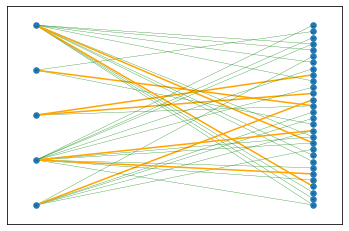

In [125]:
G = nx.Graph()
G.add_nodes_from(draw_fir, bipartite=0)
G.add_nodes_from(draw_sec,bipartite=1)
#G.add_edges_from([(16, 8964), (501, 9252), (629, 9759), (729, 9925), (4774, 10142)])
G.add_edges_from(list(draw_r.keys()))
nx.set_edge_attributes(G, draw_r)
bipartite.is_bipartite(G)
color_attr = nx.get_edge_attributes(G, "color")
width_attr = nx.get_edge_attributes(G, "width")
colors = []
widths = []
for i in list(G.edges):
  colors.append(color_attr[i])
  widths.append(width_attr[i])
f = plt.figure()
nx.draw_networkx(G, pos = nx.drawing.layout.bipartite_layout(G, draw_fir), width = widths, node_size = 30,font_size = 1,edge_color= colors,ax=f.add_subplot(111))
f.savefig("graph_before_pre.png")

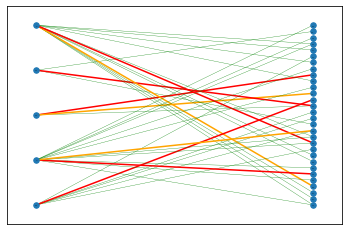

In [126]:
G = nx.Graph()
G.add_nodes_from(draw_fir, bipartite=0)
G.add_nodes_from(draw_sec,bipartite=1)
#G.add_edges_from([(16, 8964), (501, 9252), (629, 9759), (729, 9925), (4774, 10142)])
G.add_edges_from(list(draw_r.keys()))
nx.set_edge_attributes(G, draw_pre)
bipartite.is_bipartite(G)
color_attr = nx.get_edge_attributes(G, "color")
width_attr = nx.get_edge_attributes(G, "width")
colors = []
widths = []
for i in list(G.edges):
  colors.append(color_attr[i])
  widths.append(width_attr[i])

f = plt.figure()
nx.draw_networkx(G, pos = nx.drawing.layout.bipartite_layout(G, draw_fir), width = widths, node_size = 30,font_size = 1,edge_color= colors,ax=f.add_subplot(111))
f.savefig("graph_after_pre.png")